<a href="https://colab.research.google.com/github/freakezoide/codigos-de-coolab/blob/main/otro_coolab_mas_parte_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# ================
# 1. LIBRERÍAS
# ================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline  # Para pipelines con SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import shap
from matplotlib.ticker import PercentFormatter
plt.style.use('ggplot')

In [22]:
# ================
# 2. CARGA Y PREPARACIÓN DE DATOS
# ================
def cargar_datos():
    df = pd.read_csv("datos_educativos_limpios.csv")

    # Convertir meses a numérico
    meses = ['Enero','Febrero','Marzo','Abril','Mayo','Junio',
             'Julio','Agosto','Setiembre','Octubre','Noviembre','Diciembre']
    df['Mes'] = df['Mes'].apply(lambda x: meses.index(x)+1 if x in meses else 0)

    # Variables cíclicas
    df['Mes_sin'] = np.sin(2 * np.pi * (df['Mes'] - 1)/12)
    df['Mes_cos'] = np.cos(2 * np.pi * (df['Mes'] - 1)/12)

    # Variable objetivo mejorada
    condiciones = [
        (df['InteraccionCREA'] == 'Alta') & (df['InteraccionMAT'] == 'Alta'),
        (df['InteraccionBiblioteca'] == 'Baja') & (df['InteraccionCREA'] == 'Baja')
    ]
    opciones = ['Alta', 'Baja']
    df['NivelInteraccion'] = np.select(condiciones, opciones, default='Media')

    le = LabelEncoder()
    df['Target'] = le.fit_transform(df['NivelInteraccion'])

    return df, le

df, label_encoder = cargar_datos()

In [23]:
# ================
# 3. ANÁLISIS EXPLORATORIO
# ================
def analisis_interactividad(df):
    # Top 5 departamentos con menor interactividad
    top_departamentos = df.groupby('Departamento')['Target'].mean().nsmallest(5)

    # Mes con menor interactividad
    mes_interactividad = df.groupby('Mes')['Target'].mean().nsmallest(1)

    # Plataforma con menor uso
    plataformas = df[['InteraccionCREA','InteraccionMAT','InteraccionBiblioteca']]
    plataforma_baja = plataformas.apply(lambda x: (x == 'Baja').mean()).idxmax()

    # Ciclo con peor desempeño
    ciclo_desempeño = df.groupby('Ciclo')['Target'].mean().nsmallest(1)

    return top_departamentos, mes_interactividad, plataforma_baja, ciclo_desempeño

top_dep, peor_mes, peor_plataforma, peor_ciclo = analisis_interactividad(df)

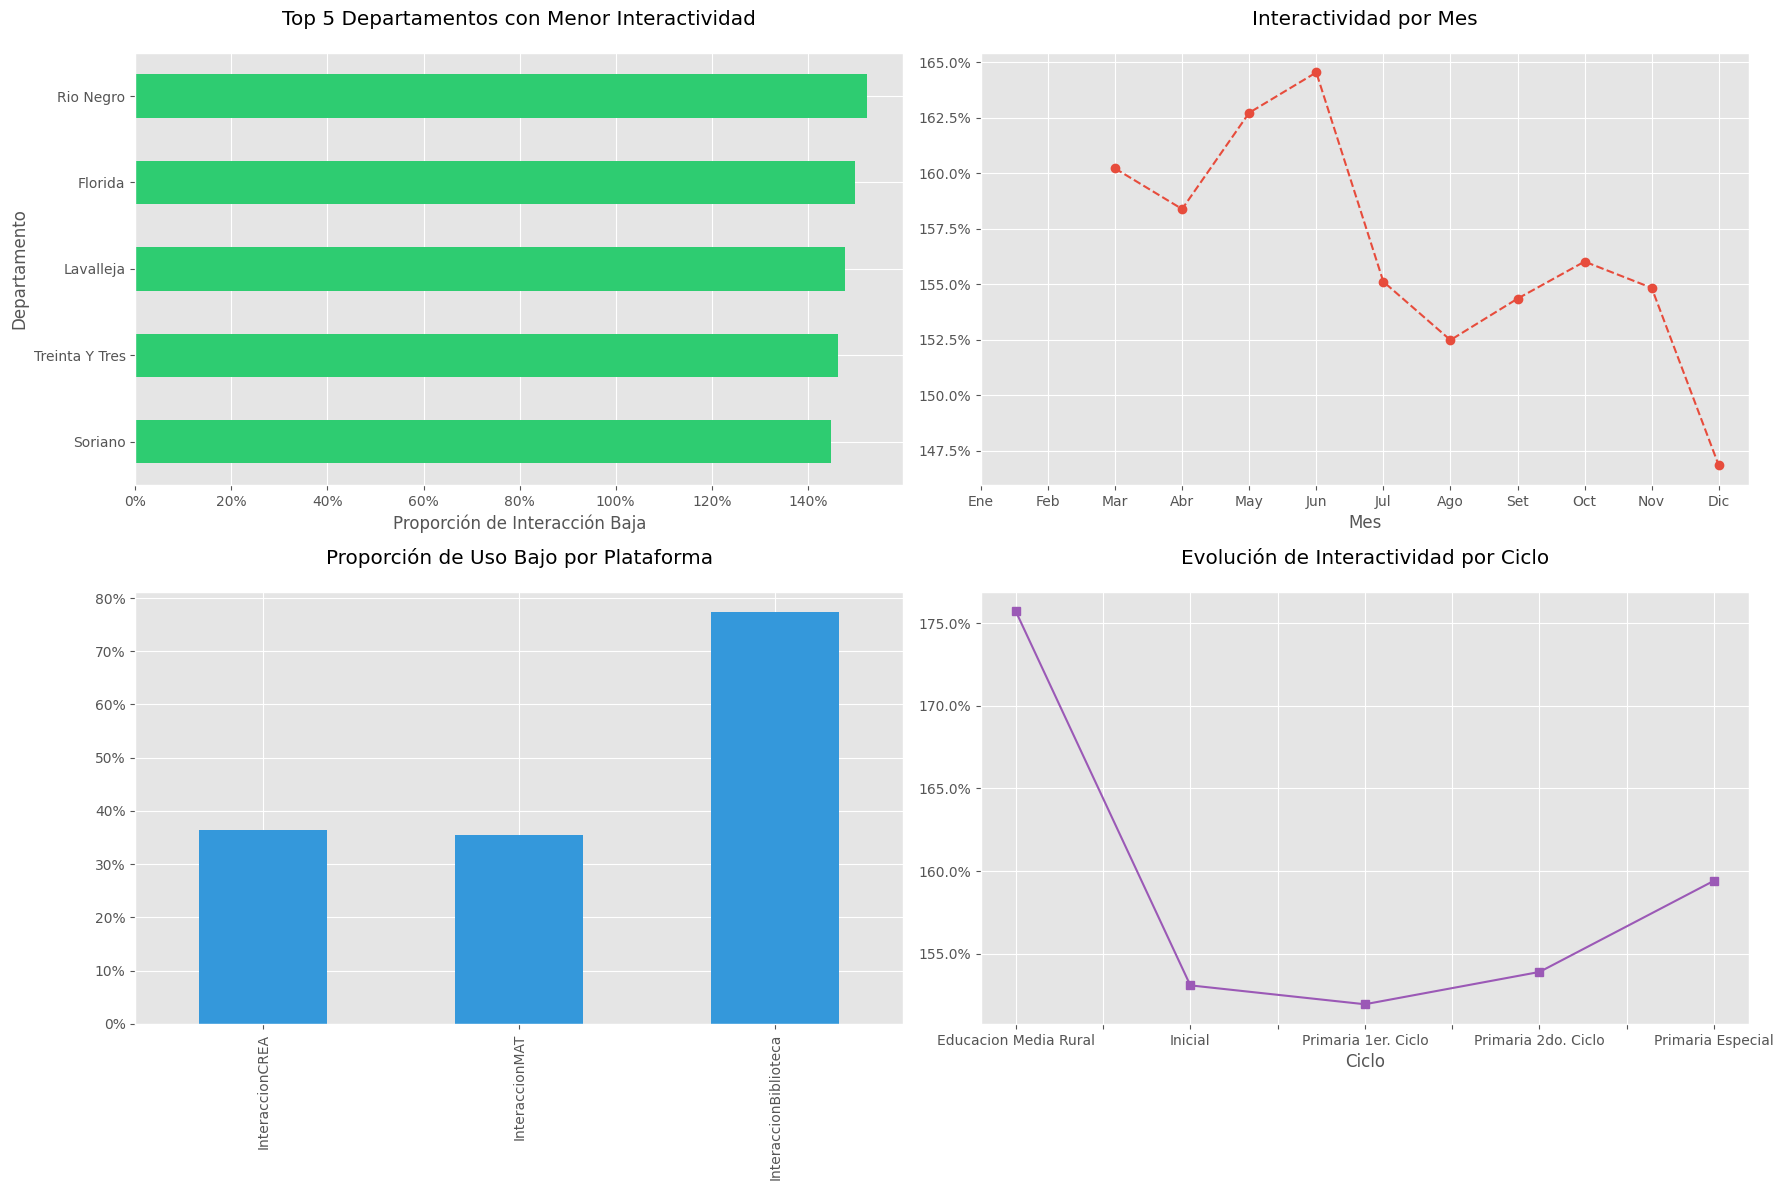

In [24]:
# ================
# 4. VISUALIZACIONES PROFESIONALES
# ================
def crear_visualizaciones():
    fig, axs = plt.subplots(2, 2, figsize=(18, 12))

    # Gráfico 1: Top departamentos
    top_dep.plot(kind='barh', ax=axs[0,0], color='#2ecc71')
    axs[0,0].set_title('Top 5 Departamentos con Menor Interactividad', pad=20)
    axs[0,0].set_xlabel('Proporción de Interacción Baja')
    axs[0,0].xaxis.set_major_formatter(PercentFormatter(1.0))

    # Gráfico 2: Tendencia mensual
    meses_orden = ['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Set','Oct','Nov','Dic']
    df.groupby('Mes')['Target'].mean().reindex(range(1,13)).plot(
        ax=axs[0,1], marker='o', color='#e74c3c', linestyle='--')
    axs[0,1].set_title('Interactividad por Mes', pad=20)
    axs[0,1].set_xticks(range(1,13))
    axs[0,1].set_xticklabels(meses_orden)
    axs[0,1].yaxis.set_major_formatter(PercentFormatter(1.0))

    # Gráfico 3: Plataformas
    (df[['InteraccionCREA','InteraccionMAT','InteraccionBiblioteca']] == 'Baja').mean().plot(
        kind='bar', ax=axs[1,0], color='#3498db')
    axs[1,0].set_title('Proporción de Uso Bajo por Plataforma', pad=20)
    axs[1,0].yaxis.set_major_formatter(PercentFormatter(1.0))

    # Gráfico 4: Ciclos
    df.groupby('Ciclo')['Target'].mean().plot(
        kind='line', ax=axs[1,1], marker='s', color='#9b59b6')
    axs[1,1].set_title('Evolución de Interactividad por Ciclo', pad=20)
    axs[1,1].yaxis.set_major_formatter(PercentFormatter(1.0))

    plt.tight_layout()
    plt.show()

crear_visualizaciones()

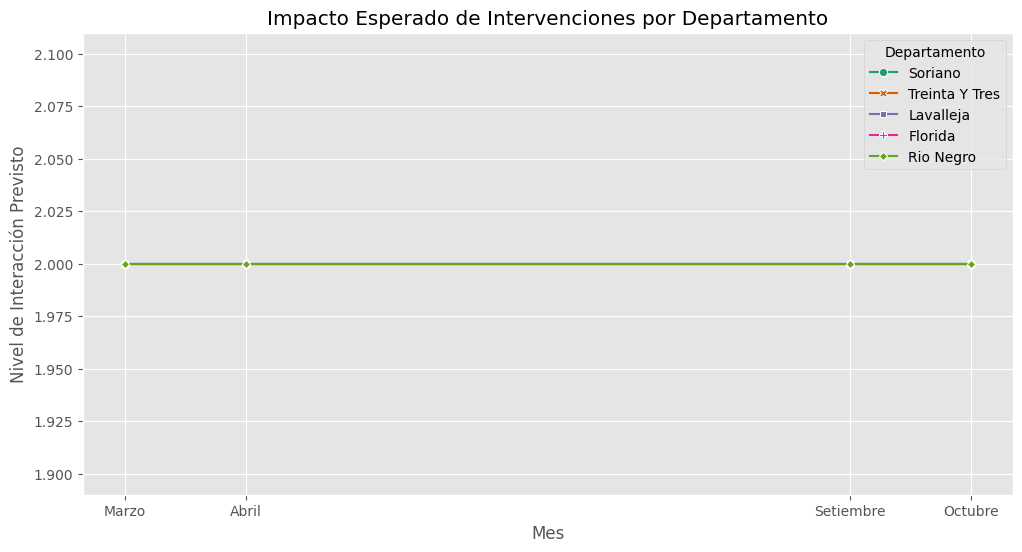

In [28]:
# ================
# 5. MODELADO MEJORADO
# ================
# Preparar datos
from imblearn.pipeline import Pipeline  # Para pipelines con SMOTE
from sklearn.compose import ColumnTransformer
X = df[['Departamento', 'Mes_sin', 'Mes_cos', 'Año', 'Ciclo',
        'InteraccionCREA', 'InteraccionMAT', 'InteraccionBiblioteca']]
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Pipeline optimizado
from imblearn.pipeline import Pipeline # Import Pipeline from imblearn instead of sklearn
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(sparse_output=False), ['Departamento', 'Ciclo', # Set sparse_output to False in OneHotEncoder
                             'InteraccionCREA', 'InteraccionMAT', 'InteraccionBiblioteca']),
    ('num', StandardScaler(), ['Mes_sin', 'Mes_cos', 'Año'])
])

pipeline = Pipeline([ # Use Pipeline from imblearn
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)), # SMOTE will now work correctly
    ('pca', PCA(n_components=0.95, svd_solver='full')), # or svd_solver='arpack' if you prefer to work with sparse matrices
    ('model', RandomForestClassifier(n_estimators=200,
                                   class_weight='balanced_subsample',
                                   max_depth=10,
                                   random_state=42))
])

pipeline.fit(X_train, y_train)

def predecir_intervenciones():
    # Generar escenarios
    meses_estrategicos = [3, 4, 9, 10]  # Inicios de trimestre
    future_data = pd.DataFrame({
        'Departamento': top_dep.index.tolist() * len(meses_estrategicos),
        'Mes': np.repeat(meses_estrategicos, 5),
        'Año': 2024,
        'Ciclo': peor_ciclo.index[0],
        'InteraccionCREA': 'Media',
        'InteraccionMAT': 'Media',
        'InteraccionBiblioteca': 'Media'
    })

    # Añadir características cíclicas
    future_data['Mes_sin'] = np.sin(2 * np.pi * (future_data['Mes'] - 1)/12)
    future_data['Mes_cos'] = np.cos(2 * np.pi * (future_data['Mes'] - 1)/12)

    # Predecir
    future_data['Prediccion'] = pipeline.predict(future_data)
    future_data['Interaccion'] = label_encoder.inverse_transform(future_data['Prediccion'])

    # Visualización interactiva
    plt.figure(figsize=(12,6))
    sns.lineplot(data=future_data, x='Mes', y='Prediccion', hue='Departamento',
                 style='Departamento', markers=True, dashes=False, palette='Dark2')
    plt.title('Impacto Esperado de Intervenciones por Departamento')
    plt.xticks(meses_estrategicos, ['Marzo','Abril','Setiembre','Octubre'])
    plt.ylabel('Nivel de Interacción Previsto')
    plt.show()

    return future_data

intervenciones_df = predecir_intervenciones()

In [30]:
# ================
# 7. REPORTE EJECUTIVO
# ================
# Define meses_orden here
meses_orden = ['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Set','Oct','Nov','Dic']

print(f"\nREPORTE DE INTERACTIVIDAD - PRINCIPALES HALLAZGOS")
print("=================================================")
print(f"Departamentos Críticos: {', '.join(top_dep.index.tolist())}")
print(f"Mes con Menor Interactividad: {peor_mes.index[0]} ({peor_mes.values[0]:.1%})")
print(f"Plataforma con Mayor Problemas: {peor_plataforma}")
print(f"Ciclo con Peor Desempeño: {peor_ciclo.index[0]} ({peor_ciclo.values[0]:.1%})")
# ================
# 7. REPORTE EJECUTIVO
# ================
print(f"\nREPORTE DE INTERACTIVIDAD - PRINCIPALES HALLAZGOS")
print("=================================================")
print(f"Departamentos Críticos: {', '.join(top_dep.index.tolist())}")
print(f"Mes con Menor Interactividad: {peor_mes.index[0]} ({peor_mes.values[0]:.1%})")
print(f"Plataforma con Mayor Problemas: {peor_plataforma}")
print(f"Ciclo con Peor Desempeño: {peor_ciclo.index[0]} ({peor_ciclo.values[0]:.1%})")
print("\nRecomendaciones:")
print("- Implementar capacitaciones específicas en los departamentos críticos")
print(f"- Priorizar mejoras en la plataforma {peor_plataforma}")
print(f"- Planificar intervenciones intensivas en {meses_orden[peor_mes.index[0]-1]}") # Now meses_orden is accessible


REPORTE DE INTERACTIVIDAD - PRINCIPALES HALLAZGOS
Departamentos Críticos: Soriano, Treinta Y Tres, Lavalleja, Florida, Rio Negro
Mes con Menor Interactividad: 12 (146.8%)
Plataforma con Mayor Problemas: InteraccionBiblioteca
Ciclo con Peor Desempeño: Primaria 1er. Ciclo (152.0%)

REPORTE DE INTERACTIVIDAD - PRINCIPALES HALLAZGOS
Departamentos Críticos: Soriano, Treinta Y Tres, Lavalleja, Florida, Rio Negro
Mes con Menor Interactividad: 12 (146.8%)
Plataforma con Mayor Problemas: InteraccionBiblioteca
Ciclo con Peor Desempeño: Primaria 1er. Ciclo (152.0%)

Recomendaciones:
- Implementar capacitaciones específicas en los departamentos críticos
- Priorizar mejoras en la plataforma InteraccionBiblioteca
- Planificar intervenciones intensivas en Dic
